# https://www.kaggle.com/c/mercari-price-suggestion-challenge 
# https://www.kaggle.com/c/home-credit-default-risk

Выбрать одно из двух соревнований. Выбирайте по данным, с которыми вам интереснее работать.

In [1]:
import time
import re
from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# Ансамбли

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

### Используйте параметр nrows, чтобы уменьшить выборку и сделать базовый разведочный анализ данных

In [21]:
// df = pd.read_csv('e:/DS/ds_hw/mercari/train.tsv', nrows=100000, sep='\t')

In [188]:
df = pd.read_csv('e:/DS/ds_hw/mercari/train.tsv',  sep='\t')

In [189]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
!head mercari/sample_submission.csv

test_id,price
0,26.738
1,26.738
2,26.738
3,26.738
4,26.738
5,26.738
6,26.738
7,26.738
8,26.738


In [10]:
df_test = pd.read_csv('e:/DS/ds_hw/mercari/test.tsv', sep='\t')

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


In [12]:
df_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


Посмотрим на данные, общие статистики

In [191]:
df['price'].max(), df['price'].min(), df['price'].mean(),   df['price'].median()

(2009.0, 0.0, 26.737516146330442, 17.0)

Посмотрим распределение товаров по категориям

In [60]:
x = df['main_category'].value_counts().index.values.astype('str')
y = df['main_category'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(df))]

In [38]:
y

array([664385, 207828, 171689, 122690,  93680,  67871,  46530,  45351,
        30842,  25342,   6327], dtype=int64)

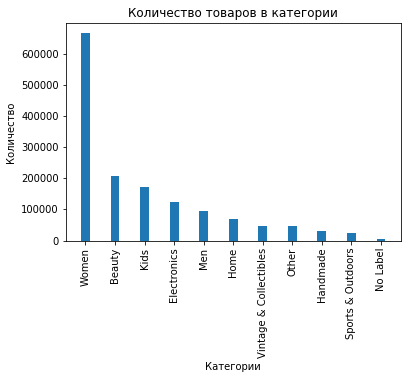

In [39]:

plt.bar(x,y,width=.3)
plt.xticks(x,x, rotation='vertical')
plt.xlabel('Категории')
plt.ylabel('Количество ')
plt.title('Количество товаров в категории')
plt.show()

Категориии детализированы очень подробно, поэтому каждый товар в опрделенной категории, очень схожи, те если 
это джинсовые леггинсы, то каждый представитель этой категории очень похож на любой другой. Поэтому учитывая бранд 
и состояние можно уже сделать предсказание цены, с каким-то усреднением.



In [192]:
df.brand_name.fillna(value="Missing", inplace=True)


In [193]:
df[df['brand_name'].isnull()].count()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [194]:
df = df[df['category_name'].notnull()]

In [195]:
le = LabelEncoder()
le.fit(df.brand_name)
df['brand_name_i'] = le.transform(df.brand_name)

le.fit(df.category_name)
df['category_name_i'] = le.transform(df.category_name)

In [208]:
le.fit(df.name)
df['name_i'] = le.transform(df.name)

In [196]:
df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,brand_name_i,category_name_i
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Missing,10.00,1,No description yet,2876,808
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,3545,86
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,4166,1254
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Missing,35.00,1,New with tags. Leather horses. Retail for [rm]...,2876,485
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Missing,44.00,0,Complete with certificate of authenticity,2876,1181


In [209]:
cols = ['item_condition_id','category_name_i','brand_name_i', 'shipping']
x = df[cols]
y = df['price']


In [210]:
# Попробуем xgb
model = xgb.XGBRegressor()
model.fit(x, y)
y_pred = model.predict(x)
y_pred = [round(value,2) for value in y_pred]
# evaluate predictions
mse = mean_squared_error(y, y_pred)
print("MSE: %.2f " % mse)

r2 = r2_score(y, y_pred)
print("r2: %.2f" % r2)


MSE: 1195.50 
r2: 0.20


Попробуем линейную регрессию, как baseline

In [211]:
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, tree, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
regr = linear_model.LinearRegression()

In [212]:
from sklearn.metrics import explained_variance_score

In [213]:
x.shape

(1476208, 4)

In [214]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y ,test_size=0.2)

In [215]:
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [216]:
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f " % mse)

MSE: 1473.26 


In [217]:
r2 = r2_score(y_test, y_pred)
print("r2: %.2f" % r2)

r2: 0.01


In [222]:
regr.score(X_test,y_test)


0.01365107762091744

In [223]:
xgb_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [224]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [225]:
predictions = xgb_reg.predict(X_test)
print(explained_variance_score(predictions,y_test))

-1.872912021513188


In [99]:
predictions

array([14.78355 , 10.208202, 16.915178, ..., 13.96363 , 12.218944,
       19.189688], dtype=float32)

In [15]:
from scipy.stats import pearsonr
features = df[cols].columns.tolist()
target = df['price'].name

In [16]:
correlations = {}
for f in features:
    data_temp = df[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [96]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
shipping vs price,-0.10
brand_name vs price,-0.05
category_name vs price,0.05
item_condition_id vs price,-0.00
name vs price,-0.00


In [149]:
df[df.columns[5:10]].corr()

,price,shipping,brand_name_i,category_name_i
price,1.00,-0.10,-0.05,0.05
shipping,-0.10,1.00,0.02,-0.14
brand_name_i,-0.05,0.02,1.00,-0.03
category_name_i,0.05,-0.14,-0.03,1.00


In [152]:
df_t = df[df['category_name']=='Men/Tops/T-shirts']

In [153]:
df_t['price'].mean(), df_t['price'].min(), df_t['price'].max(), df_t['price'].std()


(18.35249536669314, 0.0, 309.0, 16.307762207703092)

In [154]:
df_t = df_t[df_t['price'] <=40]

In [155]:
df_t = df_t[df_t['price'] > 5]


In [159]:
from scipy.stats import pearsonr

features = df_t[cols].columns.tolist()
target = df_t['price'].name

In [160]:
correlations = {}
for f in features:
    data_temp = df_t[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [161]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
item_condition_id vs price,-0.25
shipping vs price,-0.10
brand_name_i vs price,0.06
name_i vs price,0.02
category_name_i vs price,nan


# Задание
1. Сделать baseline submission
  * Исследовать признак price. 
  * Исследовать признак price в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
  * ...
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Скорректировать план
  * убрать пункты, которые кажутся неудачными
  * добавить идеи из kernel, кажущиеся удачными
7. Построить модель, выбрать лучшую
8. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
9. Применить и засабмитить лучшую на cv модель
10. Прислать блокнот и свой ник в лидерборде